In [1]:
%matplotlib inline

In [2]:
import os
from astropy.table import Table

#  MDPL2-based mock
dirname = "/Users/aphearin/work/random/0331"
basename = "cutmock_1e9.hdf5"
fname = os.path.join(dirname, basename)
mock = Table.read(fname, path='data')
mask = mock['x'] < 200
mask *= mock['y'] < 200
mask *= mock['z'] < 200
mock = mock[mask]
mock.Lbox = 200.


/Users/aphearin/anaconda/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
morange = u'#ff7f0e'
mblue = u'#1f77b4'
mgreen = u'#2ca02c'
mred = u'#d62728'
mpurple = u'#9467bd'

import os
from astropy.table import Table
v4_prerelease_dirname = "/Users/aphearin/Dropbox/protoDC2/v4_prerelease"
v4_prerelease_fname = os.path.join(
    v4_prerelease_dirname, "v4_prerelease_no_interpolation.hdf5")
v4 = Table.read(v4_prerelease_fname, path='data')
print(v4.keys())

['redshift', 'mstar', 'hostHaloMass', 'isCentral', 'mag_g', 'mag_r', 'mag_i', 'mag_g_obs', 'mag_r_obs', 'mag_i_obs', 'Lum_g', 'Lum_r', 'Lum_i', 'disk_mag_r', 'bulge_mag_r', 'lum_tot_r', 'bulge_rhalf_arcsec', 'disk_rhalf_arcsec', 'bt', 'ang_diam_dist_Mpc', 'bulge_rhalf_kpc_phys', 'disk_rhalf_kpc_phys']


In [4]:
from cosmodc2.sdss_colors import load_umachine_processed_sdss_catalog
sdss = load_umachine_processed_sdss_catalog()
print(sdss.keys())

['ra', 'dec', 'z', 'sm', 'ssfr', 'nd', 'restframe_extincted_sdss_abs_magr', 'restframe_extincted_sdss_gr', 'restframe_extincted_sdss_ri', 'size_kpc', 'dr7_PhotoObj_Table_ID', 'sfr_percentile_fixed_sm', 'gr_percentile_fixed_magr']


In [12]:
from cosmodc2.sdss_colors import magr_monte_carlo

def remap_mag_r_obs(mag_r_obs_old, mag_r_abs_old, mag_r_abs_new):
    dmag_r = mag_r_obs_old - mag_r_abs_old
    mag_r_obs_new = dmag_r + mag_r_abs_new
    return mag_r_obs_new

def remap_mag_i_obs(mag_r_abs_old, mag_i_abs_old, mag_i_obs_old, mag_r_abs_new):
    ri_abs_old = mag_r_abs_old - mag_i_abs_old
    mag_i_abs_new = ri_abs_old - mag_r_abs_new
    dmag_i = mag_i_obs_old - mag_i_abs_old
    mag_i_obs_new = dmag_i + mag_i_abs_new
    return mag_i_abs_new, mag_i_obs_new

v4['mag_r_new'] = magr_monte_carlo(v4['mstar'], v4['redshift'],
                        boost_table=[0, -0.2, -0.5, -1.])
v4['mag_r_obs_new'] = remap_mag_r_obs(v4['mag_r_obs'], v4['mag_r'], v4['mag_r_new'])

mag_i_abs_new, mag_i_obs_new = remap_mag_i_obs(
    v4['mag_r'], v4['mag_i'], v4['mag_i_obs'], v4['mag_r_new'])

from cosmodc2.sdss_colors import gr_ri_monte_carlo

sfr_percentile_mock = np.random.rand(len(v4))

gr, ri, is_quiescent_ri, is_quiescent_gr = gr_ri_monte_carlo(
    v4['mag_r_new'], sfr_percentile_mock, v4['redshift'])

v4['ri_new'] = ri
v4['gr_new'] = gr

v4['mag_g_abs_new'] = v4['mag_r_new'] + v4['gr_new']
v4['mag_i_abs_new'] = v4['mag_r_new'] - v4['ri_new']

dmag_i = v4['mag_i_obs'] - v4['mag_i']
v4['mag_i_obs_new'] = dmag_i + v4['mag_i_abs_new']

print(v4.keys())

['redshift', 'mstar', 'hostHaloMass', 'isCentral', 'mag_g', 'mag_r', 'mag_i', 'mag_g_obs', 'mag_r_obs', 'mag_i_obs', 'Lum_g', 'Lum_r', 'Lum_i', 'disk_mag_r', 'bulge_mag_r', 'lum_tot_r', 'bulge_rhalf_arcsec', 'disk_rhalf_arcsec', 'bt', 'ang_diam_dist_Mpc', 'bulge_rhalf_kpc_phys', 'disk_rhalf_kpc_phys', 'mag_r_new', 'mag_r_obs_new', 'ri_new', 'gr_new', 'mag_g_abs_new', 'mag_i_abs_new', 'mag_i_obs_new']


## HSC cumulative LF validation test 

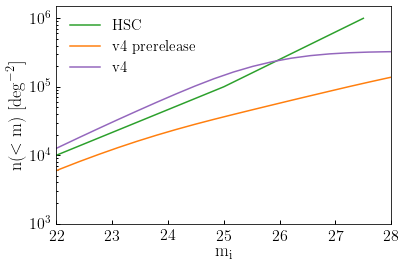

In [13]:
magarr = np.linspace(20, 30, 30)
magmasks = list((v4['mag_i_obs'] < m) for m in magarr)
counts = np.array([np.count_nonzero(mask) for mask in magmasks])
magmasks_new = list((v4['mag_i_obs_new'] < m) for m in magarr)
counts_new = np.array([np.count_nonzero(mask) for mask in magmasks_new])

sky_area = 25.
fig, ax = plt.subplots(1, 1)
yscale = ax.set_yscale('log')

hsc_ordinates = [1e4, 1e5, 1e6]
hsc_abscissa = [22, 25, 27.5]
__=ax.plot(hsc_abscissa, hsc_ordinates, label=r'${\rm HSC}$', color=mgreen)

__=ax.plot(magarr, counts/sky_area, label=r'${\rm v4\ prerelease}$', color=morange)
__=ax.plot(magarr, counts_new/sky_area, label=r'${\rm v4}$', color=mpurple)

xlabel = ax.set_xlabel(r'${\rm m_{i}}$')
ylabel = ax.set_ylabel(r'${\rm n(<m)\ [deg^{-2}]}$')
legend = ax.legend()
ylim = ax.set_ylim(1e3, 1.5e6)
xlim = ax.set_xlim(22, 28)


## Compare cumulative number density to Zehavi+11

In [14]:
from cosmodc2.sdss_colors import zehavi11_cumulative_nd
lumthresh_h1p0, cumnd_sdss = zehavi11_cumulative_nd()

from cosmodc2.mock_diagnostics import cumulative_nd

volume_v4 = mock.Lbox**3.
protoDC2_littleh = 0.7
cumnd_pdc2_v4 = cumulative_nd(mock['mag_r_new'], 
                           volume_v4, protoDC2_littleh, lumthresh_h1p0)
cumnd_pdc2_v4_new2 = cumulative_nd(mock['mag_r_new2'], 
                           volume_v4, protoDC2_littleh, lumthresh_h1p0)


KeyError: 'mag_r_new'

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharex=True)

__=ax1.plot(lumthresh_h1p0, np.log10(cumnd_sdss), label=r'${\rm Zehavi+11}$', color=mgreen)
__=ax1.plot(lumthresh_h1p0, np.log10(cumnd_pdc2_v4), 
            label=r'${\rm v4}$', color=mblue)
__=ax1.plot(lumthresh_h1p0, np.log10(cumnd_pdc2_v4_new2), 
            label=r'${\rm v4\ alt}$', color=mpurple)

fracdiff_pdc2_v4 = (cumnd_pdc2_v4 - cumnd_sdss)/cumnd_sdss
fracdiff_pdc2_v4_new2 = (cumnd_pdc2_v4_new2 - cumnd_sdss)/cumnd_sdss

__=ax2.plot(lumthresh_h1p0, fracdiff_pdc2_v4, 
            label=r'${\rm v4}$', color=mblue)
__=ax2.plot(lumthresh_h1p0, fracdiff_pdc2_v4_new2, 
            label=r'${\rm v4\ alt}$', color=mpurple)
__=ax2.plot(np.linspace(-100, 100, 100), np.zeros(100), ':', color='k')

legend = ax1.legend()
legend2 = ax2.legend()
xlabel = ax1.set_xlabel(r'${\rm M_{r}}$')
xlabel2 = ax2.set_xlabel(r'${\rm M_{r}}$')
ylabel2 = ax2.set_ylabel(r'${\rm fractional\ error}$')
ylabel = ax1.set_ylabel(r'$n(<{\rm M_r})\ [(h/{\rm Mpc})^3]$')
title1 = ax1.set_title(r'${\rm z=0\ luminosity\ function\ test}$')
title2 = ax2.set_title(r'${\rm z=0\ luminosity\ function\ test}$')
ax2.yaxis.tick_right()  
xlim1 = ax1.set_xlim(-18, -22.3)
ylim2 = ax2.set_ylim(-1, 1)

figname = 'v4_hsc_recalibration_zehavi11_nd.pdf'
fig.savefig(figname, bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')

In [ ]:
from cosmodc2.mock_diagnostics import zehavi_wp

period = mock.Lbox
x, y, z, vz = mock['x'], mock['y'], mock['z'], mock['vz']

magr = mock['mag_r_new']
rp_mids, wp_v4_19p0_new = zehavi_wp(x, y, z, vz, 
            period, magr, -19.0, protoDC2_littleh)
rp_mids, wp_v4_19p5_new = zehavi_wp(x, y, z, vz, 
            period, magr, -19.5, protoDC2_littleh)
rp_mids, wp_v4_20p5_new = zehavi_wp(x, y, z, vz, 
            period, magr, -20.5, protoDC2_littleh)
rp_mids, wp_v4_21p5_new = zehavi_wp(x, y, z, vz, 
            period, magr, -21.5, protoDC2_littleh)


In [ ]:
magr = mock['mag_r_new2']
rp_mids, wp_v4_19p0_new2 = zehavi_wp(x, y, z, vz, 
            period, magr, -19.0, protoDC2_littleh)
rp_mids, wp_v4_19p5_new2 = zehavi_wp(x, y, z, vz, 
            period, magr, -19.5, protoDC2_littleh)
rp_mids, wp_v4_20p5_new2 = zehavi_wp(x, y, z, vz, 
            period, magr, -20.5, protoDC2_littleh)
rp_mids, wp_v4_21p5_new2 = zehavi_wp(x, y, z, vz, 
            period, magr, -21.5, protoDC2_littleh)


In [ ]:
from cosmodc2.sdss_colors.sdss_measurements import rp as rp_zehavi
from cosmodc2.sdss_colors import zehavi11_clustering

wp_zehavi_18p5 = zehavi11_clustering(-18.5)
wp_zehavi_19p0 = zehavi11_clustering(-19.0)
wp_zehavi_19p5 = zehavi11_clustering(-19.5)
wp_zehavi_20p0 = zehavi11_clustering(-20.0)
wp_zehavi_20p5 = zehavi11_clustering(-20.5)
wp_zehavi_21p0 = zehavi11_clustering(-21.0)
wp_zehavi_21p5 = zehavi11_clustering(-21.5)

fig, _axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)

((ax1, ax2), (ax3, ax4)) = _axes
axes = ax1, ax2, ax3, ax4
for ax in axes:
    __=ax.loglog()


__=ax1.plot(rp_mids, wp_v4_19p0_new,  color=mblue, label=r'${\rm v4\ M_{r} < -19}$')
__=ax1.plot(rp_mids, wp_v4_19p0_new2,  color=mpurple, label=r'${\rm v4\ alt}$')
__=ax1.errorbar(rp_zehavi, wp_zehavi_19p0, 0.2*wp_zehavi_19p0, 
               fmt='.', color='blue')

__=ax2.plot(rp_mids, wp_v4_19p5_new,  color=mblue, label=r'${\rm v4\ M_{r} < -19.5}$')
__=ax2.plot(rp_mids, wp_v4_19p5_new2,  color=mpurple, label=r'${\rm v4\ alt}$')
__=ax2.errorbar(rp_zehavi, wp_zehavi_19p5, 0.2*wp_zehavi_19p5, 
               fmt='.', color='blue')

__=ax3.plot(rp_mids, wp_v4_20p5_new,  color=mblue, label=r'${\rm v4\ M_{r} < -20.5}$')
__=ax3.plot(rp_mids, wp_v4_20p5_new2,  color=mpurple, label=r'${\rm v4\ alt}$')
__=ax3.errorbar(rp_zehavi, wp_zehavi_20p5, 0.2*wp_zehavi_20p5, 
               fmt='.', color='blue')

__=ax4.plot(rp_mids, wp_v4_21p5_new,  color=mblue, label=r'${\rm v4\ M_{r} < -21.5}$')
__=ax4.plot(rp_mids, wp_v4_21p5_new2,  color=mpurple, label=r'${\rm v4\ alt}$')
__=ax4.errorbar(rp_zehavi, wp_zehavi_21p5, 0.2*wp_zehavi_21p5, 
               fmt='.', color='blue')

for ax in axes:
    leg = ax.legend()

title1 = ax1.set_title(r'${\rm protoDC2-v4\ clustering\ vs.\ SDSS}$')
title2 = ax2.set_title(r'${\rm protoDC2-v4\ clustering\ vs.\ SDSS}$')

xlabel3 = ax3.set_xlabel(r'${\rm r_p\ [Mpc]}$')
xlabel4 = ax4.set_xlabel(r'${\rm r_p\ [Mpc]}$')
ylabel1 = ax1.set_ylabel(r'${\rm w_p(r_p)\ [Mpc]}$')
ylabel3 = ax3.set_ylabel(r'${\rm w_p(r_p)\ [Mpc]}$')

__=ax1.set_xticklabels([''])
__=ax2.set_xticklabels([''])

figname = 'v4_hsc_recalibration_zehavi11_wp.pdf'
fig.savefig(figname, bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')

In [ ]:
print(mock.keys())

In [ ]:
cenmask = mock['upid'] == -1

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
xscale1 = ax1.set_xscale('log')

__=ax1.scatter(mock['mvir'][cenmask][::100], mock['mag_r_new'][cenmask][::100], s=0.1,
              color='gray')

mw_halo_mask = (mock['mvir'] > 10**11.75) & (mock['mvir'] < 10**12.25)
group_halo_mask = (mock['mvir'] > 10**13.) & (mock['mvir'] < 10**13.5)
cluster_halo_mask = (mock['mvir'] > 10**14.) 


from scipy.stats import gaussian_kde 

mw_halo_kde = gaussian_kde(mock['mag_r_new2'][cenmask & mw_halo_mask])
group_halo_kde = gaussian_kde(mock['mag_r_new2'][cenmask & group_halo_mask])
cluster_halo_kde = gaussian_kde(mock['mag_r_new2'][cenmask & cluster_halo_mask])

magr_array = np.linspace(-25, -16, 100)

mw_halo_pdf = mw_halo_kde.evaluate(magr_array)
group_halo_pdf = group_halo_kde.evaluate(magr_array)
cluster_halo_pdf = cluster_halo_kde.evaluate(magr_array)

__=ax2.fill(magr_array, mw_halo_pdf, color=mblue, alpha=0.8, 
           label=r'${\rm M_{halo}\approx10^{12}M_{\odot}}$')
__=ax2.fill(magr_array, group_halo_pdf, color=mgreen, alpha=0.8,
           label=r'${\rm M_{halo}\approx10^{13.25}M_{\odot}}$')
__=ax2.fill(magr_array, cluster_halo_pdf, color=mred, alpha=0.8,
           label=r'${\rm M_{halo}>10^{14}M_{\odot}}$')

xlim1 = ax1.set_xlim(1e10, 1e14)
ylim1 = ax1.set_ylim(-17, -23.5)
xlabel1 = ax1.set_xlabel(r'${\rm M_{vir}}$')
ylabel1 = ax1.set_ylabel(r'${\rm M_{r}}$')

xlim2 = ax2.set_xlim(-18, -25)
ylim2 = ax2.set_ylim(0, 1.35)
xlabel2 = ax2.set_xlabel(r'${\rm M_{r}}$')

title1 = ax1.set_title(r'${\rm z=0\ mass}$-${\rm to}$-${\rm light\ ratio}$')
title2 = ax2.set_title(r'${\rm z=0\ central\ galaxy\ CLF}$')
legend2 = ax2.legend()

figname = 'v4_hsc_recalibration_clf_z0.pdf'
fig.savefig(figname, bbox_extra_artists=[xlabel1, ylabel1], bbox_inches='tight')